# Створення нейронної мережі

У цьому завданні ми створимо повнозв'язну нейронну мережу, використовуючи при цьому низькорівневі механізми tensorflow.

Архітектура нейромережі представлена на наступному малюнку. Як бачиш, у ній є один вхідний шар, два приховані, а також вихідний шар. В якості активаційної функції у прихованих шарах буде використовуватись сигмоїда. На вихідному шарі ми використовуємо softmax.

Частина коду зі створення мережі вже написана, тобі потрібно заповнити пропуски у вказаних місцях.

## Архітектура нейронної мережі

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>


## Про датасет MNIST

Дану нейромережу ми будемо вивчати на датасеті MNIST. Цей датасет являє собою велику кількість зображень рукописних цифр розміром $28 \times 28$ пікселів. Кожен піксель приймає значення від 0 до 255.

Як і раніше, датасет буде розділений на навчальну та тестову вибірки. При цьому ми виконаємо нормалізацію всіх зображень, щоб значення пікселів знаходилось у проміжку від 0 до 1, розділивши яскравість кожного пікселя на 255.

Окрім того, архітектура нейронної мережі очікує на вхід вектор. У нашому ж випадку кожен об'єкт вибірки являє собою матрицю. Що ж робити? У цьому завданні ми "розтягнемо" матрицю $28 \times 28$, отримавши при цьому вектор, що складається з 784 елементів.

![MNIST Dataset](https://www.researchgate.net/profile/Steven-Young-5/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)

Більше інформації про датасет можна знайти [тут](http://yann.lecun.com/exdb/mnist/).

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import keras as K
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [2]:
num_classes = 10 # загальна кількість класів, у нашому випадку це цифри від 0 до 9
num_features = 784 # кількість атрибутів вхідного вектора 28 * 28 = 784

learning_rate = 0.001 # швидкість навчання нейронної мережі
training_steps = 3000 # максимальне число епох
batch_size = 256 # перераховувати ваги мережі ми будемо не на всій вибірці, а на її випадковій підмножині з batch_size елементів
display_step = 100 # кожні 100 ітерацій ми будемо показувати поточне значення функції втрат і точності

n_hidden_1 = 128 # кількість нейронів 1-го шару
n_hidden_2 = 256 # кількість нейронів 2-го шару

In [3]:
# from tensorflow.keras.datasets import mnist
from keras.datasets import mnist

# Завантажуємо датасет
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Перетворюємо цілочисельні пікселі на тип float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Перетворюємо матриці розміром 28x28 пікселів у вектор з 784 елементів
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Нормалізуємо значення пікселів
x_train, x_test = x_train / 255., x_test / 255.

# Перемішаємо тренувальні дані
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

11490434/11490434 [==============================] - 8s 1us/step


In [4]:
# Створимо нейронну мережу

class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        self.w = tf.Variable(
            tf.random.normal([in_features, out_features]), name="w"
        )
        self.b = tf.Variable(tf.zeros([out_features]), name="b")

    def __call__(self, x, activation=0):
        y = tf.matmul(x, self.w) + self.b
        if activation != 0:
            return tf.nn.softmax(y)
        else:
            return tf.nn.sigmoid(y)

class NN(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)
    # Перший шар, який складається з 128 нейронів
    self.layer_1 = DenseLayer(in_features=num_features, out_features=n_hidden_1)
    # Другий шар, який складається з 256 нейронів
    self.layer_2 = DenseLayer(in_features=n_hidden_1, out_features=n_hidden_2)
    # Вихідний шар
    self.out_layer = DenseLayer(in_features=n_hidden_2, out_features=num_classes)


  def __call__(self, x):
    # Передача даних через перші два шари та вихідний шар з функцією активації softmax
    x1 = self.layer_1(x, activation=0)
    x2 = self.layer_2(x1, activation=0)

    return self.out_layer(x2, activation=1)

In [5]:
# В якості функції помилки в даному випадку зручно взяти крос-ентропію
def cross_entropy(y_pred, y_true):
    # Закодувати label в one hot vector
    y_true = tf.one_hot(y_true, depth=num_classes)

    # Значення передбачення, щоб уникнути помилки log(0).
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)

    # Обчислення крос-ентропії
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

# Як метрику якості використовуємо точність
def accuracy(y_pred, y_true):
    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.cast(y_true, tf.int64))
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [6]:
# Створимо екземпляр нейронної мережі
neural_net = NN(name="mnist")

# Функція навчання нейромережі
def train(neural_net, input_x, output_y):
  # Для налаштування вагів мережі будемо використовувати стохастичний градієнтний спуск
  optimizer = tf.optimizers.SGD(learning_rate)

  # Активація автоматичного диференціювання
  with tf.GradientTape() as g:
    pred = neural_net(input_x)
    loss = cross_entropy(pred, output_y)

    # Отримаємо список оптимізованих параметрів
    # Обчислимо за ними значення градієнта
    gradients = g.gradient(loss, neural_net.trainable_variables)

    # Модифікуємо параметри
    # Застосовуємо градієнти за допомогою оптимізатора
    optimizer.apply_gradients(zip(gradients, neural_net.trainable_variables))
    
  
    

In [7]:
# Тренування мережі

loss_history = []  # кожні display_step кроків зберігай в цьому списку поточну помилку нейромережі
accuracy_history = [] # кожні display_step кроків зберігай в цьому списку поточну точність нейромережі

# У цьому циклі ми будемо проводити навчання нейронної мережі
# із тренувального датасета train_data вилучи випадкову підмножину, на якій
# відбудеться тренування. Використовуй метод take, доступний для тренувального датасета.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    # Оновлюємо ваги нейронної мережі
    train(neural_net, batch_x, batch_y)
    if step % display_step == 0:
        pred = neural_net(batch_x)
        loss = cross_entropy(neural_net(batch_x), batch_y)
        loss_history.append(loss.numpy())
        # Обчислюємо точність
        acc = accuracy(neural_net(batch_x), batch_y)
        accuracy_history.append(acc.numpy())
        print(f"Step {step}, Loss: {loss.numpy()}, Accuracy: {acc.numpy()}")


Step 100, Loss: 331.2918701171875, Accuracy: 0.66796875
Step 200, Loss: 188.86798095703125, Accuracy: 0.78125
Step 300, Loss: 166.17361450195312, Accuracy: 0.8203125
Step 400, Loss: 152.32012939453125, Accuracy: 0.80859375
Step 500, Loss: 144.47801208496094, Accuracy: 0.8046875
Step 600, Loss: 120.73259735107422, Accuracy: 0.875
Step 700, Loss: 80.48357391357422, Accuracy: 0.89453125
Step 800, Loss: 114.97991943359375, Accuracy: 0.875
Step 900, Loss: 110.4074478149414, Accuracy: 0.87890625
Step 1000, Loss: 82.35208892822266, Accuracy: 0.90625
Step 1100, Loss: 119.07725524902344, Accuracy: 0.88671875
Step 1200, Loss: 89.17476654052734, Accuracy: 0.8984375
Step 1300, Loss: 96.75949096679688, Accuracy: 0.890625
Step 1400, Loss: 70.7396011352539, Accuracy: 0.9140625
Step 1500, Loss: 88.29302978515625, Accuracy: 0.90625
Step 1600, Loss: 88.19175720214844, Accuracy: 0.91015625
Step 1700, Loss: 82.69415283203125, Accuracy: 0.89453125
Step 1800, Loss: 57.15046691894531, Accuracy: 0.9375
Step 1

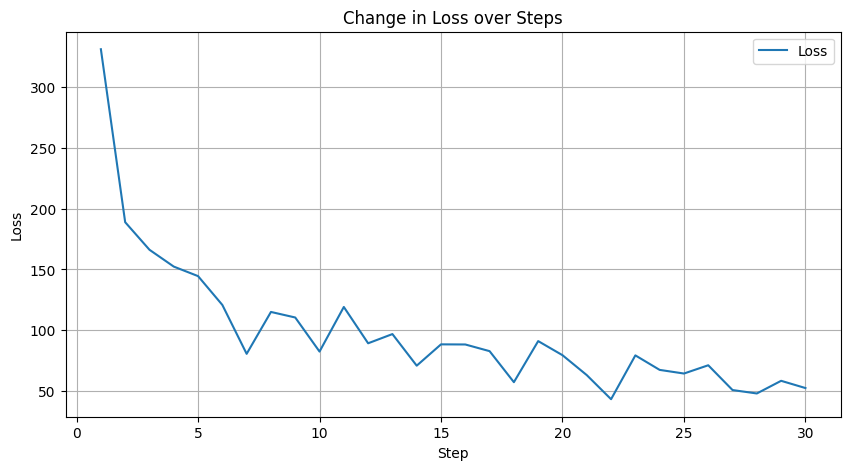

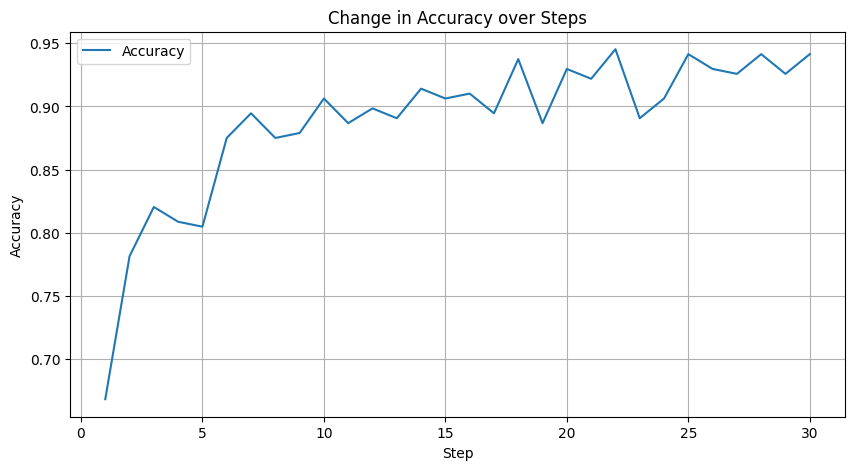

In [8]:
# Виведіть графіки залежності зміни точності і втрат від кроку
# Якщо все зроблено правильно, то точність повинна зростати, а втрати зменшуватись

import matplotlib.pyplot as plt

# Виведіть графік функції втрат
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(loss_history) + 1), loss_history, label='Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Change in Loss over Steps')
plt.legend()
plt.grid(True)
plt.show()

# Виведіть графік точності
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(accuracy_history) + 1), accuracy_history, label='Accuracy')
plt.xlabel('Step')
plt.ylabel('Accuracy')
plt.title('Change in Accuracy over Steps')
plt.legend()
plt.grid(True)
plt.show()



In [10]:
from sklearn.metrics import classification_report

# Обчисліть точність навченої нейромережі
# Тестування моделі на тестових даних
predictions = neural_net(x_test)
predicted_labels = tf.argmax(predictions, axis=1).numpy()
print(classification_report(y_test, predicted_labels))

test_acc = accuracy(predictions, y_test).numpy()
print(f"{test_acc=:%}")



              precision    recall  f1-score   support

           0       0.95      0.96      0.95       980
           1       0.97      0.97      0.97      1135
           2       0.91      0.89      0.90      1032
           3       0.91      0.85      0.88      1010
           4       0.90      0.90      0.90       982
           5       0.88      0.84      0.86       892
           6       0.91      0.95      0.93       958
           7       0.91      0.91      0.91      1028
           8       0.81      0.90      0.85       974
           9       0.89      0.87      0.88      1009

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.91      0.90      0.90     10000

test_acc=90.429997%


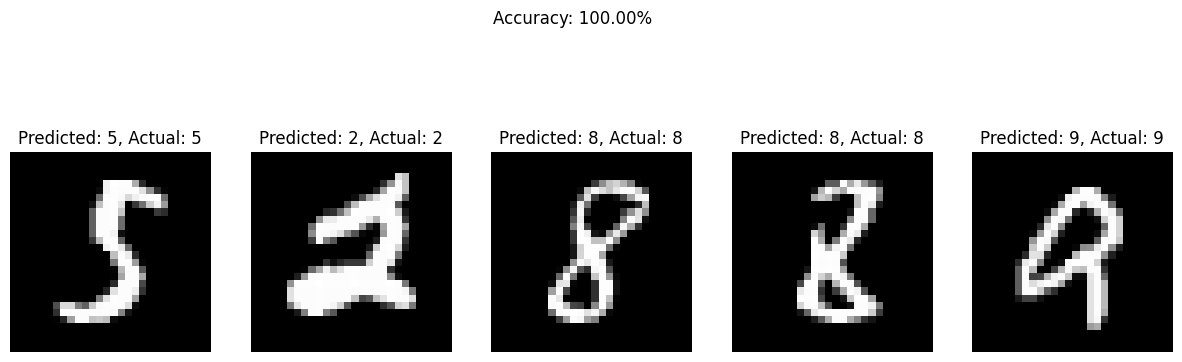

In [27]:
# Протестуйте навчену нейромережу на 10 зображеннях. З тестової вибірки візьміть 5
# випадкових зображень і передайте їх у нейронну мережу.
# Виведіть зображення та випишіть  поруч відповідь нейромережі.
# Зробіть висновок про те, чи помиляється твоя нейронна мережа, і якщо так, то як часто?


random_indices = np.random.choice(len(x_test), size=5, replace=False)
images_to_test = x_test[random_indices]
labels_to_test = y_test[random_indices]


predicted_labels = neural_net(images_to_test).numpy().argmax(axis=1)

correct_predictions = (predicted_labels == labels_to_test)
accuracy = sum(correct_predictions) / len(correct_predictions)

plt.figure(figsize=(15, 5))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(images_to_test[i].reshape(28, 28), cmap='gray')
    plt.title(f"Predicted: {predicted_labels[i]}, Actual: {labels_to_test[i]}")
    plt.axis('off')
plt.suptitle(f"Accuracy: {accuracy:.2%}")
plt.show()


# Точність 100%